In [18]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pyffx

In [43]:
# class BlockTransform(nn.Module):
#     """
#     Generic class for block-wise transformation.
#     """
# 
#     def __init__(self, config):
#         super().__init__()
#         self.block_size = config.block_size
#         assert (
#             config.height % self.block_size == 0 | config.width % self.block_size == 0
#         ), "Image not divisible by block_size"
#         self.blocks_axis0 = int(config.height / self.block_size)
#         self.blocks_axis1 = int(config.width / self.block_size)
# 
#     def segment(self, X):
#         """将输入张量 X 的维度重新排序，将通道维度从第二维移到最后一维。
#         假设输入张量形状为 (batch_size, channels, height, width)，
#         它将变为 (batch_size, height, width, channels)。"""
#         X = X.permute(0, 2, 3, 1)
#         '''将图像重新形状，分割为块。每个块的大小为 block_size x block_size，
#         而图像被分割成 blocks_axis0 x blocks_axis1 个块。'''
#         X = X.reshape(
#             -1,
#             self.blocks_axis0,
#             self.block_size,
#             self.blocks_axis1,
#             self.block_size,
#             3,
#         )
# 
#         X = X.permute(0, 1, 3, 2, 4, 5)
#         '''将这些块展平成一维向量，每个块现在被表示为一维的像素值序列。'''
#         X = X.reshape(
#             -1,
#             self.blocks_axis0,
#             self.blocks_axis1,
#             self.block_size * self.block_size * 3,
#         )
#         return X
# 
#     def integrate(self, X):
#         X = X.reshape(
#             -1,
#             self.blocks_axis0,
#             self.blocks_axis1,
#             self.block_size,
#             self.block_size,
#             3,
#         )
#         X = X.permute(0, 1, 3, 2, 4, 5)
#         X = X.reshape(
#             -1,
#             self.blocks_axis0 * self.block_size,
#             self.blocks_axis1 * self.block_size,
#             3,
#         )
#         X = X.permute(0, 3, 1, 2)
#         return X
# 
#     def generate_key(self, seed, binary=False):
#         torch.manual_seed(seed)
#         key = torch.randperm(self.block_size * self.block_size * 3)
#         if binary:
#             key = key > len(key) / 2
#         return key
# 
# 
#     def forward(self, X, decrypt=False):
#         raise NotImplementedError

# 用于打乱图像块内的像素位置。
class Shuffle:
    def __init__(self, config, image):
        self.block_size = config.block_size
        assert (
            config.height % self.block_size == 0 | config.width % self.block_size == 0
        ), "Image not divisible by block_size"
        self.blocks_axis0 = int(config.height / self.block_size)
        self.blocks_axis1 = int(config.width / self.block_size)
        self.key = self.generate_key(config.seed, binary=False) # 排列密钥
        self.image = image

    def forward(self, X, decrypt=False):
        X = self.segment(X)
        if decrypt: # 还原
            key = torch.argsort(self.key)
            X = X[:, :, :, key]
        else: # 打乱
            X = X[:, :, :, self.key]
        X = self.integrate(X)
        return X.contiguous()
    
    def segment(self, X):
        """将输入张量 X 的维度重新排序，将通道维度从第二维移到最后一维。
        假设输入张量形状为 (batch_size, channels, height, width)，
        它将变为 (batch_size, height, width, channels)。"""
        X = X.permute(0, 2, 3, 1)
        '''将图像重新形状，分割为块。每个块的大小为 block_size x block_size，
        而图像被分割成 blocks_axis0 x blocks_axis1 个块。'''
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.block_size,
            self.blocks_axis1,
            self.block_size,
            3,
        )

        X = X.permute(0, 1, 3, 2, 4, 5)
        '''将这些块展平成一维向量，每个块现在被表示为一维的像素值序列。'''
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.blocks_axis1,
            self.block_size * self.block_size * 3,
        )
        return X

    def integrate(self, X):
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.blocks_axis1,
            self.block_size,
            self.block_size,
            3,
        )
        X = X.permute(0, 1, 3, 2, 4, 5)
        X = X.reshape(
            -1,
            self.blocks_axis0 * self.block_size,
            self.blocks_axis1 * self.block_size,
            3,
        )
        X = X.permute(0, 3, 1, 2)
        return X

    def generate_key(self, seed, binary=False):
        torch.manual_seed(seed)
        key = torch.randperm(self.block_size * self.block_size * 3)
        if binary:
            key = key > len(key) / 2
        return key
    def apply(self):
        return self.forward(self.image)

In [44]:
# 定义配置类
class Config:
    def __init__(self, block_size=4, height=32, width=32, seed=2024, password="password"):
        self.block_size = block_size
        self.height = height
        self.width = width
        self.seed = seed
        self.password = password

Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
tensor([[[0.1686, 0.0000, 0.0784],
         [0.0667, 0.0314, 0.0000],
         [0.2118, 0.3255, 0.0157],
         ...,
         [0.1961, 0.3255, 0.1961],
         [0.4863, 0.4275, 0.1961],
         [0.4824, 0.1647, 0.4039]],

        [[0.2667, 0.0824, 0.2471],
         [0.0000, 0.2000, 0.1922],
         [0.1490, 0.0980, 0.1059],
         ...,
         [0.2157, 0.4784, 0.4706],
         [0.4902, 0.5098, 0.3294],
         [0.3294, 0.3412, 0.4078]],

        [[0.0706, 0.1961, 0.1882],
         [0.0000, 0.1961, 0.2431],
         [0.0314, 0.1098, 0.1804],
         ...,
         [0.1961, 0.5961, 0.5098],
         [0.1961, 0.1373, 0.5176],
         [0.4627, 0.5098, 0.3686]],

        ...,

        [[0.6745, 0.3765, 0.5843],
         [0.1333, 0.7490, 0.7294],
         [0.6588, 0.7059, 0.5647],
         ...,
         [0.2745, 0.2078, 0.3804],
         [0.8471, 0.5137, 0.2431],
         [0.5804, 0.7216, 0.38

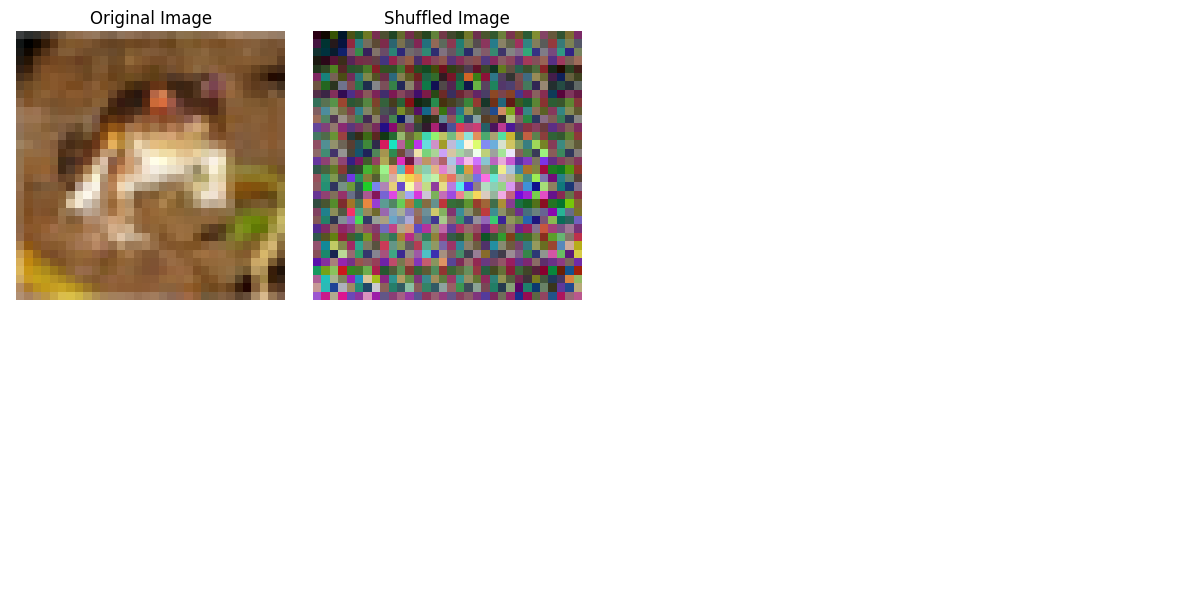

In [50]:
# 初始化配置
config = Config()

# 加载CIFAR-10数据集
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


# 获取一个样本图像
image, label = cifar10[0]
print(image.shape)
image = image.unsqueeze(0)  # 增加批次维度
print(image.shape)

# 初始化转换类
shuffle_transform = Shuffle(config,image)

# 可视化原图像及变换后的图像
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

axs[0, 0].imshow(image[0].permute(1, 2, 0))
axs[0, 0].set_title('Original Image')

# 应用Shuffle变换
shuffled_image = shuffle_transform.apply()
print(shuffled_image[0].permute(1, 2, 0))
# recovered_image = shuffle_transform(shuffled_image, decrypt=True)

axs[0, 1].imshow(shuffled_image[0].permute(1, 2, 0))
axs[0, 1].set_title('Shuffled Image')
# axs[0, 2].imshow(recovered_image[0].permute(1, 2, 0))
# axs[0, 2].set_title('Recovered Shuffled Image')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()